<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/01_a_rule_based_model_for_machine_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A rule-based model for machine perception

In this notebook, you will learn how to represent images and train basic machine learning models to classify images. You will discover that **the performance of linear and fully connected neural networks is poor on images.** However, along the way, you will learn how to use the Keras API to implement ML primitives and train ML models.

## Setup

In [1]:
import tensorflow as tf

print(tf.version.VERSION)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.6.0
Found GPU at: /device:GPU:0


In [2]:
import matplotlib.pylab as plt
import matplotlib
import numpy as np

In [3]:
!gsutil cat gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/4933229095

## A Dataset for Machine Perception

Assume that we have collected and labeled a dataset of nearly four thousand photographs of flowers. There are five types of flowers in the `5-flowers` dataset and each image in the dataset has already been labeled with the type of flower it depicts.

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/images/1.png?raw=1' width='800'/>

We are asking the machine learning model to learn to perceive what’s in the image, so you might see this type of task called machine perception. Specifically, the type of perception is analogous to human sight,
so the problem is termed computer vision, and in this case we will solve it through image classification.

### Reading Image Data

The 5-flowers dataset was created by Google and placed in the public domain with a Creative Commons license. It is published as a TensorFlow dataset and available in a public Google Cloud Storage bucket `(gs://cloud-ml-data/)` in the form of JPEG files. This makes the dataset both realistic (it consists of JPEG photographs of the sort collected by off-the-shelf cameras) and readily accessible.

There are four steps to reading an image in a standard format like JPEG or PNG and getting it ready to train machine learning models with it.

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # 1.Read the file
  img = tf.io.read_file(filename)
  # 2.Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # 3.Use `convert_image_dtype` to convert to floats in the [0,1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 4.Resize the image to the desired size
  return tf.image.resize(img, reshape_dims)

In [5]:
CLASS_NAMES = [
               item.numpy().decode("utf-8") 
               for item in tf.strings.regex_replace(tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                                                    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")
              ]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:\n", CLASS_NAMES)

These are the available classes:
 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


###Visualizing Image Data

Always visualize a few of the images to ensure that you are reading the data correctly —a common mistake is to read the data in such a way that the images are rotated or mirrored. Visualizing the images is also useful to get a sense of how challenging a machine perception problem is.

We can use Matplotlib’s `imshow()` function to visualize an image, but in order to do so we must first convert the image, which is a TensorFlow tensor, into a numpy array using the `numpy()` function.

In [6]:
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow(img.numpy())

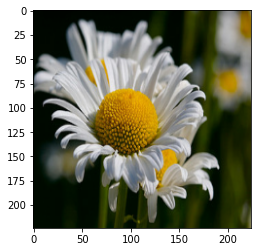

In [7]:
show_image("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

Notice that the filename contains the type of flower (daisy). This
means we can use wildcard matching with TensorFlow’s `glob()` function to get, say, all the tulip images:

gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


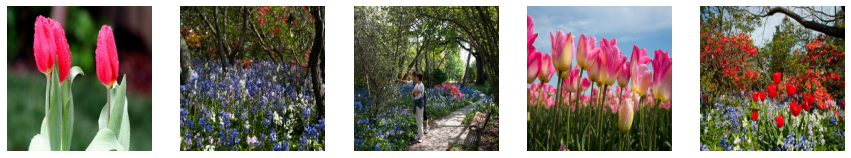

In [8]:
# notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15, 15))

for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis("off")

We know that the images in our dataset have a naming convention, we could
take a filename and extract the label using string operations. 

For example, we can remove the prefix using:

In [14]:
filename = "tulips"
basename = tf.strings.regex_replace(filename, "gs://cloud-ml-data/img/flower_photos/", "")
label = tf.strings.split(basename, "/")[0]  # get the category name
print(label)

tf.Tensor(b'tulips', shape=(), dtype=string)


In [15]:
tf.strings.split(tf.strings.regex_replace(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", ""),
    '/')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

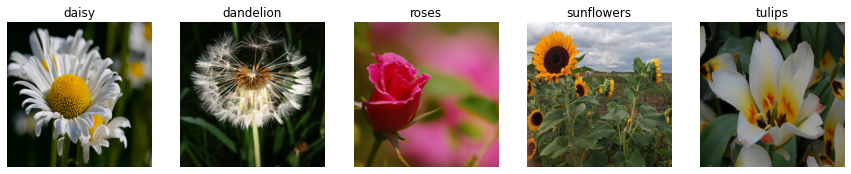

In [16]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis('off')

### Reading the Dataset File

Let's get the average color of RGB values in the different
types of flowers and then classify an unknown image as
belonging to closest centroid.

In [17]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  # label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label_string

One way to read a CSV file is to read in text lines using TextLineDataset, passing in a function to handle each line as it is read through the `map()` function:

In [18]:
dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv))

To verify that this code works, we can print out the average pixel value for each channel of the first three images in the training dataset:

In [19]:
for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1])  # average pixel in the image
  print(label, avg)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


Note that the label is a string tensor and the average is a 1D tensor of length 3. Why did we get a 1D tensor? That’s because we passed in an axis parameter to
`reduce_mean()`.

TensorFlow would have computed the mean along all the dimensions and returned a scalar value. 

Recall that the shape of the image is `[IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS]`. Therefore, by providing `axis=[0, 1]`, we are asking TensorFlow to compute the average of all columns (axis=0) and all rows `(axis=1)`, but not to average the RGB values.

<img src='https://github.com/rahiakela/computer-vision-research-and-practice/blob/main/practical-machine-learning-for-computer-vision/02-ml-models-for-vision/images/2.png?raw=1' width='800'/>



## Create a rule-based model

In [20]:
class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant(0., dtype=tf.float32)
    self.count_so_far = 0
  
  def update(self, value):
    self.sum_so_far = self.sum_so_far + value
    self.count_so_far = self.count_so_far + 1
    if self.count_so_far%100 == 0:
      print(self.label, self.count_so_far)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
  def __init__(self):
    self.centroids = {
        f: Centroid(f) for f in CLASS_NAMES}

  def fit(self, dataset):
    for img, label in dataset:
      label = label.numpy().decode("utf-8")
      avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
      self.centroids[label].update(avg)
  
  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
    best_label = ""
    best_diff = 999
    for key, val in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
      if diff < best_diff:
        best_diff = best_diff
        best_label = key
    return best_label
  
  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label in dataset:
      correct = label.numpy().decode('utf-8')
      predicted = self.predict(img)
      if correct == predicted:
        num_correct = num_correct + 1
      total_images = total_images + 1
    accuracy = num_correct / total_images
    return(accuracy)

### Train the rule-based model

In [21]:
rule = CentroidRule()

# to try it on the full dataset, remove the .take(500)
train_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)).take(500)
eval_dataset = (tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").map(decode_csv)).take(50)

rule.fit(train_dataset)

# There is not much separation between the classes
print(rule.centroids["daisy"])
print(rule.centroids["roses"])

# let's evaluate it
rule.evaluate(eval_dataset)

dandelion 100
tulips 100
daisy [0.44554377 0.44968474 0.3594977 ]
roses [0.46776444 0.37675467 0.31471127]


0.24

### Prediction with the rule-based model

That's pretty much a random guess!!

In [23]:
# this is how you'd use the model to predict
filename = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"
img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
pred = rule.predict(img)
print(pred)

tulips
